# Skeleton of Assignment 4:
    test if the distribution of 
    
    1) trip duration of bikers that ride during the day vs night
    
    2) age of bikers for trips originating in Manhattan and in Brooklyn
    
    are different. Use 3 tests: KS, Pearson's, Spearman's. 
    
    Use the scipy.stats functions scipy.stats.ks_2samp, scipy.stats.pearsonr, scipy.stats.spearmanr. 
    
    For the KS do the test with the entire dataset and with a subset 200 times smaller
    
    Choose a single significant threshold for the whole exercise. 
    
    For each test phrase the Null Hypothesis in words.
    
    Describe the return of the scipy function you use in each case.
    
    State the result in terms of rejection of the Null.

In [43]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import os

%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2018")
    
import os
import json

Populating the interactive namespace from numpy and matplotlib


In [44]:
os.getenv('PUIDATA')

'/nfshome/pl1840/PUIdata'

# Read in data
I am reading in data from January 2015 with the function that I created getCitiBikeCSV. You are requested to use 2 months at least. It would be a good idea to use data from a colder and a warmer months, since there are more riders in the warm weather and ridership patterns may change with weather, temperature, etc. You should use data from multiple months, joining multiple datasets (thus addressing some systematic errors as well)

In [45]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [46]:
df1 = '201502'
getCitiBikeCSV(df1)

file in place, you can continue


In [47]:
df2 = '201506'
getCitiBikeCSV(df2)

file in place, you can continue


In [48]:
#df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df1 = pd.read_csv(os.getenv("PUIDATA") + "/" + df1 + '-citibike-tripdata.csv')
df2 = pd.read_csv(os.getenv("PUIDATA") + "/" + df2 + '-citibike-tripdata.csv')
frames = [df1, df2]
df = pd.concat(frames,ignore_index=True)
df.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,801,2/1/2015 0:00,2/1/2015 0:14,521,8 Ave & W 31 St,40.750450,-73.994811,423,W 54 St & 9 Ave,40.765849,-73.986905,17131,Subscriber,1978.0,2
1,379,2/1/2015 0:00,2/1/2015 0:07,497,E 17 St & Broadway,40.737050,-73.990093,504,1 Ave & E 15 St,40.732219,-73.981656,21289,Subscriber,1993.0,1
2,2474,2/1/2015 0:01,2/1/2015 0:42,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,127,Barrow St & Hudson St,40.731724,-74.006744,18903,Subscriber,1969.0,2
3,818,2/1/2015 0:01,2/1/2015 0:15,2004,6 Ave & Broome St,40.724399,-74.004704,505,6 Ave & W 33 St,40.749013,-73.988484,21044,Subscriber,1985.0,2
4,544,2/1/2015 0:01,2/1/2015 0:10,323,Lawrence St & Willoughby St,40.692362,-73.986317,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,19868,Subscriber,1957.0,1


In [49]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

# Day and night trip duration

### SPLIT BY CATEGORY

Splitting data by day and night and looking at trip duration:

**H0: there is no statistical difference in the trip duration distribution during the day and the night**
$$ \alpha = 0.05 $$

- extracting the time happens in the cell below

In [50]:
df['hour'] = pd.to_datetime(df['starttime'],format="%m/%d/%Y %H:%M").dt.hour

In [51]:
df['Day'] = df['tripduration'][(df['hour'] >= 6) & (df['hour'] < 18)]
df['Night'] = df['tripduration'][((df['hour'] >= 18) & (df['hour'] <= 23)) |((df['hour'] >= 0) & (df['hour'] < 6))]

In [53]:
#dropping some data I no longer need
df.drop(['stoptime','start station name', 'end station id','end station name', 'end station latitude', 'end station longitude', 'bikeid','usertype', 'birth year','gender', 'start station latitude', 'start station longitude', 'start station id'], axis=1, inplace=True)
df.head()

,tripduration,starttime,hour,Day,Night
0,801,2/1/2015 0:00,0,NaN,801.0
1,379,2/1/2015 0:00,0,NaN,379.0
2,2474,2/1/2015 0:01,0,NaN,2474.0
3,818,2/1/2015 0:01,0,NaN,818.0
4,544,2/1/2015 0:01,0,NaN,544.0


In [54]:
#your df should look something like this
# look at these data carefully... you may see someinteresting values!
df.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,tripduration,hour,Day,Night
count,1.138149e+06,1.138149e+06,7.841760e+05,353973.000000
mean,8.604430e+02,1.396376e+01,8.655135e+02,849.210036
std,3.156855e+03,4.931966e+00,3.384458e+03,2582.111764
min,6.000000e+01,0.000000e+00,6.000000e+01,60.000000
25%,3.870000e+02,1.000000e+01,NaN,NaN
50%,6.150000e+02,1.500000e+01,NaN,NaN
75%,1.008000e+03,1.800000e+01,NaN,NaN
max,1.691873e+06,2.300000e+01,1.691873e+06,518019.000000


In [55]:
# dropping NaN values
df['Day'].dropna(inplace= True)
df['Night'].dropna(inplace= True)

the next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

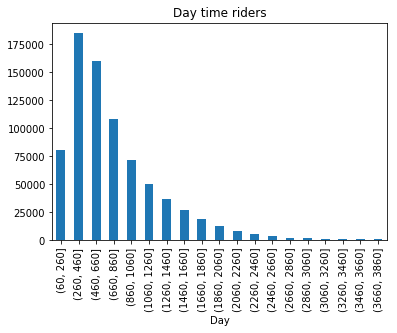

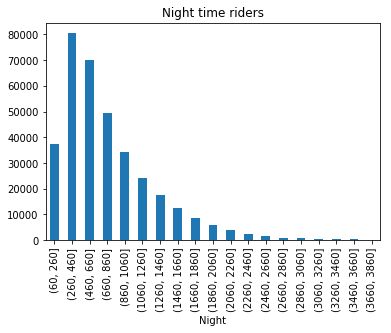

In [56]:
# plotting histogramswith pandas is a bitdifferent than with pylab
# this is a VERY USEFUL syntaxfor you to knonw!
bins = np.arange(60, 4000, 200)
axD = df.Day.groupby(pd.cut(df.Day, bins)).agg([count_nonzero]).plot(kind='bar', 
                                                                legend=False)
axD.set_title("Day time riders")
axN = df.Night.groupby(pd.cut(df.Night, bins)).agg([count_nonzero]).plot(kind='bar',
                                                                legend=False)
axN.set_title("Night time riders");


**Figure 1: histogrammed distribution of tripduration by day and night time rider**
*It is obvious from the above graphs that day time riders and night time riders has nearly identical distribution, but the scale of count are different: day time rides are obviously higher than night time rides. But note that we define day as 12 hours, from 6 to 18, while night we only define it as 5 hours, from 18 to 23. So in this case, we cannot draw any conclusion about the distribution difference bewteen day and night yet.*

This is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to reat an observed distribution like a probablility distribution i have to normalize it

              count_nonzero
Day                        
(60, 260]          0.002107
(260, 460]         0.007306
(460, 660]         0.014065
(660, 860]         0.012326
(860, 1060]        0.007062
(1060, 1260]       0.003110
(1260, 1460]       0.000920
(1460, 1660]       0.000161
(1660, 1860]       0.000546
(1860, 2060]       0.000956
(2060, 2260]       0.001310
(2260, 2460]       0.001241
(2460, 2660]       0.001421
(2660, 2860]       0.001100
(2860, 3060]       0.000842
(3060, 3260]       0.000739
(3260, 3460]       0.000476
(3460, 3660]       0.000280
(3660, 3860]       0.000000


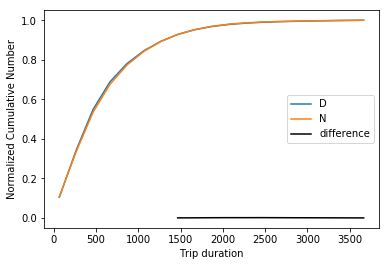

In [57]:
#print df.ageS, df.ageS.cumsum()

csD=df.Day.groupby(pd.cut(df.Day, bins)).agg([count_nonzero]).cumsum()

csN=df.Night.groupby(pd.cut(df.Night, bins)).agg([count_nonzero]).cumsum()

print (np.abs(csD / csD.max()-csN / csN.max()))

pl.plot(bins[:-1] + 5, csD / csD.max(), label = "D")
pl.plot(bins[:-1] + 5, csN / csN.max(), label = "N")
pl.plot(bins[:-1] + 5, np.sqrt(csN / csN.max() - csD / csD.max())**2, 'k-',
        label = "difference")
pl.xlabel("Trip duration")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

** Figure 2: the cumulative distribution of CitiBike riders' trip duration group by day and night.** The cumulative distribution of day and night trip looks nearly identical, so we might suggest that there is no statistical difference in the distributions of day and night.

They look similar! But the difference gets to 10%. If I wanted to code the KS test by hand I woud have everything I need: the normalized cumulative distributions can be subtracted from each other and the max distance can calculated. 

Notice that there may be NaN values you are gonna have to deal with! 
You can do that for example with a Boolean statementsuch as  df.ageF[~np.isnan(df.ageF)] or you can use numpy functions that deal with Nan values: nansum, nanmean, nanstd...

lets run the scipy KS test

In [58]:
import scipy.stats
#remember that your imports should all be at the top. I leave it here to hightlight that this package is needed at this point of the workflow

# KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html

the KS test in scipy returns the p-value BUT make sure you understand what the NULL is! read the documentation carefully! what is the null hypothesis that you can/cannot reject?

**Null hypothesis: the distriutions of two samples comes from the same parent distribution**

$\alpha$ = 0.05

In [59]:
ks = scipy.stats.ks_2samp(df.Day, df.Night)
print (ks)

Ks_2sampResult(statistic=0.012400661792720369, pvalue=5.1269005588815236e-33)


**Answer:** From the output above, we have test statistic equals to 0.0124, and p-value which is very small - nearly equal to zero. The null hypothesis in this test is day and night has same distriution. We can reject the null hypothesis at 0.05 significance level and conclude that the two samples does not have identical distribution.



The scipy.stats KS test already tells me the significance and the p-value. 

The next few cells are here just to show you how you would obtain the same result by hand, but they are **not required**. 

Remember: the Null hypothesis is rejected if 

$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1 + n2)}{n1n2}}$

(see class notes) where $c(\alpha$) is the inverse of the KS distribution, and you do not have to know how to get that cause there are tables that list critical values!! 

http://www.real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/kolmogorov-smirnov-test/kolmogorov-distribution/

But also this result depends in your choice of binning through, and thus the result you get by hand may not be exactly the same as the one the KS returns. Either way: this is how you would calculate the KS statistics by hand.

**Null hypothesis: the distriution of two reduced samples are comes from the same parent distribution**

$\alpha$ = 0.05

In [60]:
random.seed(555)
k1 = np.random.choice(df.Day,100,replace=False)
k2 = np.random.choice(df.Night,100,replace=False)
ks = scipy.stats.ks_2samp(k1, k2)
print(ks)

Ks_2sampResult(statistic=0.10999999999999999, pvalue=0.55601716622975694)


**Answer:** the test statistic is 0.11 with corresponding p-value equal to 0.556, so we cannot reject null hypothesis at 0.05 significance level. Therefore, we cannot conclude that the distriution of two reduced samples are comes from different distributions.

# Now retest using a test for correlation. 

That will answer a slightly different question though - formulate the NULL appropriately. The tests for correlations (generally) requires the variable to be paired, so that I can tell if x changes does y change similarly. But the datasets are of different size! You will need to reduce them to the same size. You can do that by subsampling of the data: take only 1 ride every of 200, which you can achieve "slicing and broadcasting" the array or using one of the python function (built in python numpy.random.choice() functions for example: Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

        .. versionadded:: 1.7.0

Parameters
...

But make sure you understand how to use it! there is an option "replace" which you should think about.

# Pearson's  test for correlation

** notice that the Pearson's is a pairwise test: the samples need to be **
 a. the same size
 b. sorted! (how??)
    
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



**Null hypothesis: the two samples are not statistically correlated**


$\alpha$ = 0.05

In [61]:
# your code here!
# wrangle the data as needed
# please perform the Pearson's test 
# and tell me what you find in terms of NULL hypothesis
random.seed(555)
p1 = np.sort(np.random.choice(df.Day, 5000,replace=False))
p2 = np.sort(np.random.choice(df.Day, 5000,replace=False))
scipy.stats.pearsonr(p1, p2)

(0.97038707551593462, 0.0)

**Answer:** The correlation of these two samples is 0.97 which is very close to 1, which implies that these two samples has very strong positive correlation. The p-value is 0 which we can reject null hypothesis and conclude that there is a statistically significance relationship between two samples.

# Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

**Null hypothesis: there is no monotonic association between two samples**

$\alpha$ = 0.05

In [62]:
# your code here!
# wrangle the data as needed
# please perform the Spearman's test and tell me what you find in terms of NULL hypothesis
random.seed(555)
s1 = np.random.choice(df.Day,5000,replace=False)
s2 = np.random.choice(df.Night,5000,replace=False)
scipy.stats.spearmanr(s1,s2)

SpearmanrResult(correlation=-0.0074878104335118368, pvalue=0.59656739893853272)

**Answer:** The correlation of two samples is -0.0075 which indicate a slighlt negative correlation between day trip duration and night trip duration. The p-value is 0.597 whichi is larger than 0.05 significance level, so we cannot reject null hypothesis: the two samples does not have a monotonic association between each other.